In [34]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from urllib.parse import urlparse, unquote
from scipy.sparse import hstack
from tqdm import tqdm  # Importing tqdm for progress bar
from keras.layers import Dense, Dropout, BatchNormalization, Input, LSTM, Embedding, SpatialDropout1D
from keras.callbacks import Callback
from keras.layers import Input
from keras.utils import Progbar
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [35]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("GPU is being used for training.")
else:
    print("GPU is not being used.")

Num GPUs Available:  1
GPU is being used for training.


I0000 00:00:1751272223.661468   30573 gpu_device.cc:2019] Created device /device:GPU:0 with 9396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [36]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [37]:
# Step 1: Load and inspect the dataset
file_path = '/mnt/partition1/machine_learning/phising_email_detection/CEAS_08.csv'
data = pd.read_csv(file_path)
data.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [38]:
data['body_length'] = data['body'].apply(lambda x: len(str(x).split()))  # Length of the email body in words
max_sequence_length = data['body_length'].max()
print(f"Maximum sequence length (max body length in words): {max_sequence_length}")

Maximum sequence length (max body length in words): 19863


In [ ]:
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and digits
    text = text.lower()
    return text

def extract_urls(text):
    urls = re.findall(r'http\S+|www\S+|https\S+', text)
    return urls

def extract_domain(url):
    try:
        url = unquote(url)
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url

        parsed_url = urlparse(url)
        return parsed_url.netloc  # Return the domain (netloc)
    except ValueError:
        return ""

In [40]:
data['cleaned_body'] = data['body'].apply(clean_text)
data['urls'] = data['body'].apply(extract_urls)

# Create features based on URLs
data['num_urls'] = data['urls'].apply(lambda x: len(x))
data['has_url'] = data['num_urls'].apply(lambda x: 1 if x > 0 else 0)
data['url_domains'] = data['urls'].apply(lambda x: [extract_domain(url) for url in x])

data.head()

,sender,receiver,date,subject,body,label,urls,body_length,cleaned_body,num_urls,has_url,url_domains
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,[http://whitedone.com/],46,buck up your troubles caused by small dimensio...,1,1,[whitedone.com]
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,[http://www.brightmade.com],9,\nupgrade your sex and pleasures with these te...,1,1,[www.brightmade.com]
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,[http://www.cnn.com/video/partners/email/index...,302,the daily top from cnncom top videos and sto...,24,1,"[www.cnn.com, www.cnn.com, www.cnn.com, www.cn..."
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,[http://en.wikipedia.org/wiki/.so_%28domain_na...,2660,would anyone object to removing so from this l...,655,1,"[en.wikipedia.org, svn.apache.org, svn.apache...."
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,[http://7iwfna.blu.livefilestore.com/y1pXdX3kw...,2,\nwelcomefastshippingcustomersupport\nhttpiwfn...,1,1,[7iwfna.blu.livefilestore.com]


In [41]:
def tokenize_and_pad(data, max_sequence_length=None, num_words=10000):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(data)

    sequences = tokenizer.texts_to_sequences(data)
    if max_sequence_length is None:
        max_sequence_length = max([len(seq) for seq in sequences])

    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    return padded_sequences, tokenizer

In [42]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))  # Using bigrams and trigrams
X_text = vectorizer.fit_transform(data['cleaned_body'])

# Combine the URL-based features with the text features
X_urls = data[['has_url', 'num_urls']]  # Use has_url and num_urls as features

# Domain features using TF-IDF for the domains
X_domains = data['url_domains'].apply(lambda x: ' '.join(x))  # Join domains to use in vectorizer
vectorizer_domains = TfidfVectorizer(max_features=500)  # Limit domain features to avoid overfitting
X_domains = vectorizer_domains.fit_transform(X_domains)

# Combine all features into one matrix (Text, URL, and Domain-based features)
X = hstack([X_text, X_urls.values, X_domains])

# Labels (Phishing or Not)
y = data['label']
X_padded, tokenizer = tokenize_and_pad(data['cleaned_body'], max_sequence_length=max_sequence_length, num_words=10000)

In [43]:
# Train-Test Split
X_train_ml, X_test_ml, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm = train_test_split(X_padded, test_size=0.2, random_state=42)
# train_dataset_lstm = tf.data.Dataset.from_tensor_slices((X_train_lstm, y_train))
# test_dataset_lstm = tf.data.Dataset.from_tensor_slices((X_test_lstm, y_test))
# train_dataset_lstm = train_dataset_lstm.shuffle(buffer_size=10000).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
# test_dataset_lstm = test_dataset_lstm.batch(8)
X_train_ml.shape[1]
X_train_lstm.shape[1]

19863

In [44]:
# def build_8_layer_lstm_model(input_dim, max_sequence_length):
#     model = Sequential()

#     # Embedding layer
#     model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=max_sequence_length))
#     model.add(SpatialDropout1D(0.2))  # Dropout to prevent overfitting

#     # Stacked LSTM layers (8 layers)
#     model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 1st LSTM layer
#     model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 2nd LSTM layer
#     model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 3rd LSTM layer
#     model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 4th LSTM layer
#     model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 5th LSTM layer
#     model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))   # 6th LSTM layer
#     model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))   # 7th LSTM layer
#     model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))                         # 8th LSTM layer

#     # Output layer (binary classification)
#     model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

#     # Compile the model
#     model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#     return model

def build_lstm_model(input_dim, max_sequence_length):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=max_sequence_length))
    model.add(SpatialDropout1D(0.2))  # Dropout to prevent overfitting

    # Stacked LSTM layers with fewer neurons
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 1st LSTM layer
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # 2nd LSTM layer
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))  # 3rd LSTM layer

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [45]:
class ProgressBar(Callback):
    def on_epoch_end(self, epoch, logs=None):
        tqdm.write(f"Epoch {epoch + 1} completed.")

def train_lstm_nn(model, X_train, y_train, epochs=10, batch_size=32):
    progress_bar = ProgressBar()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[progress_bar])

In [46]:
# input_dim = len(tokenizer.word_index) + 1  # Vocabulary size
# lstm_model = build_lstm_model(input_dim=input_dim, max_sequence_length=max_sequence_length)
# # lstm_model.fit(train_dataset_lstm, epochs=10)
# train_lstm_nn(lstm_model, X_train_lstm, y_train, epochs=3, batch_size=16)

In [ ]:
def build_neural_network(input_dim):
    model = Sequential()

    # Input layer
    model.add(Input(shape=(input_dim,))) 

    model.add(Dense(512, activation='relu'))  # First hidden layer
    model.add(BatchNormalization())  # Batch normalization
    model.add(Dropout(0.3))  # Dropout to avoid overfitting

    model.add(Dense(256, activation='relu'))  # Second hidden layer
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))  # Third hidden layer
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))  # Fourth hidden layer
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))  # Fifth hidden layer
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))  # Sixth hidden layer
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [48]:
class ProgressBar(Callback):
    def on_epoch_end(self, epoch, logs=None):
        tqdm.write(f"Epoch {epoch + 1} completed.")

def train_nn(model, X_train, y_train, epochs=10, batch_size=32):
    progress_bar = ProgressBar()
    model.fit(X_train.toarray(), y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[progress_bar])

In [49]:
nn_model = build_neural_network(X_train_ml.shape[1])
train_nn(nn_model, X_train_ml, y_train, epochs=10, batch_size=16)

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.


In [50]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

In [ ]:
def calculate_log_loss(model, X_test, y_test, epsilon=1e-15):
    """Calculate log loss, avoiding division by zero errors."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]  # Get the probability of class 1 (phishing)
    else:
        proba = model.predict(X_test)  # The output of sigmoid is the probability for class 1
    proba = np.clip(proba, epsilon, 1 - epsilon)
    log_loss = -np.mean(np.log(proba) * y_test + np.log(1 - proba) * (1 - y_test))
    return log_loss

In [52]:
def evaluate_ml_model(model, X_train, X_test, y_train, y_test):
    print(f"Training {model.__class__.__name__}...")

    # Training with tqdm progress bar
    for _ in tqdm(range(1), desc=f"Training {model.__class__.__name__}"):
        model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate log loss
    log_loss = calculate_log_loss(model, X_test, y_test)

    # Displaying the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if log_loss is not None:
        print(f"Log Loss: {log_loss:.4f}")

    return accuracy, precision, recall, f1, log_loss

In [53]:
def evaluate_nn_model(model, X_train, X_test, y_train, y_test, is_lstm=False):

    if is_lstm:
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    else:
        y_pred = (model.predict(X_test.toarray()) > 0.5).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss = calculate_log_loss(model, X_test, y_test)

    # Displaying the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if log_loss is not None:
        print(f"Log Loss: {log_loss:.4f}")

    return accuracy, precision, recall, f1, log_loss

In [54]:
trained_models = {}
results = {}

# Evaluate machine learning models
for name, model in models.items():
    print(f"\nEvaluating {name} model...")
    accuracy, precision, recall, f1, log_loss = evaluate_ml_model(model, X_train_ml, X_test_ml, y_train, y_test)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Log Loss": log_loss,
    }
    trained_models[name] = model  # Save the trained model for future use


Evaluating Random Forest model...
Training RandomForestClassifier...


Training RandomForestClassifier: 100%|██████████| 1/1 [00:45<00:00, 45.22s/it]


Accuracy: 0.9930
Precision: 0.9931
Recall: 0.9942
F1 Score: 0.9937
Log Loss: 0.0479

Evaluating SVM model...
Training SVC...


Training SVC: 100%|██████████| 1/1 [11:12<00:00, 672.07s/it]


Accuracy: 0.9798
Precision: 0.9800
Recall: 0.9836
F1 Score: 0.9818
Log Loss: 0.0655

Evaluating KNN model...
Training KNeighborsClassifier...


Training KNeighborsClassifier: 100%|██████████| 1/1 [00:00<00:00, 163.45it/s]


Accuracy: 0.9005
Precision: 0.8507
Recall: 0.9952
F1 Score: 0.9173
Log Loss: 1.2159


In [55]:
print("\nEvaluating Neural Network model...")
accuracy, precision, recall, f1, log_loss = evaluate_nn_model(nn_model, X_train_ml, X_test_ml, y_train, y_test)
results["Neural Network"] = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Log Loss": log_loss,
}
trained_models["Neural Network"] = nn_model


Evaluating Neural Network model...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9954
Precision: 0.9975
Recall: 0.9942
F1 Score: 0.9958


In [56]:
# print("\nEvaluating LSTM model...")
# accuracy, precision, recall, f1, log_loss = evaluate_nn_model(lstm_model, X_train_lstm, X_test_lstm, y_train, y_test, is_lstm=True)
# results["LSTM"] = {
#     "Accuracy": accuracy,
#     "Precision": precision,
#     "Recall": recall,
#     "F1 Score": f1,
#     "Log Loss": log_loss,
# }
# trained_models["LSTM"] = lstm_model

In [57]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("-" * 50)


Model: Random Forest
Accuracy: 0.992976631336994
Precision: 0.9930971007823286
Recall: 0.9942409583045381
F1 Score: 0.9936687003568551
Log Loss: 0.04790971406603817
--------------------------------------------------

Model: SVM
Accuracy: 0.9798237772953646
Precision: 0.9800321322010558
Recall: 0.9836443215848882
F1 Score: 0.9818349045757645
Log Loss: 0.06554928127219882
--------------------------------------------------

Model: KNN
Accuracy: 0.900523560209424
Precision: 0.8507286333202048
Recall: 0.995162404975812
F1 Score: 0.9172948295997452
Log Loss: 1.2158917979003323
--------------------------------------------------

Model: Neural Network
Accuracy: 0.9954028859660324
Precision: 0.997457822972036
Recall: 0.9942409583045381
F1 Score: 0.9958467928011075
Log Loss: None
--------------------------------------------------


<Figure size 600x600 with 0 Axes>

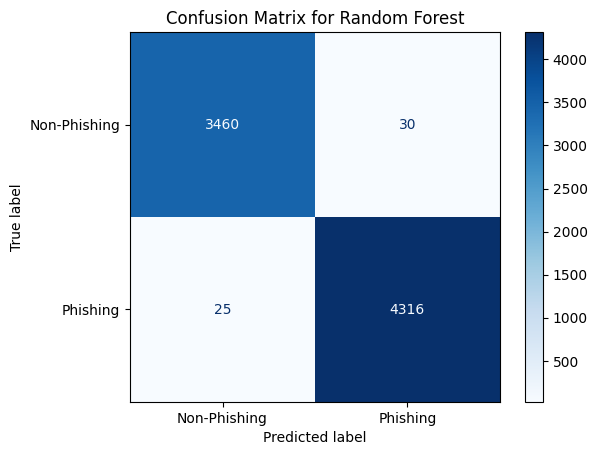

<Figure size 600x600 with 0 Axes>

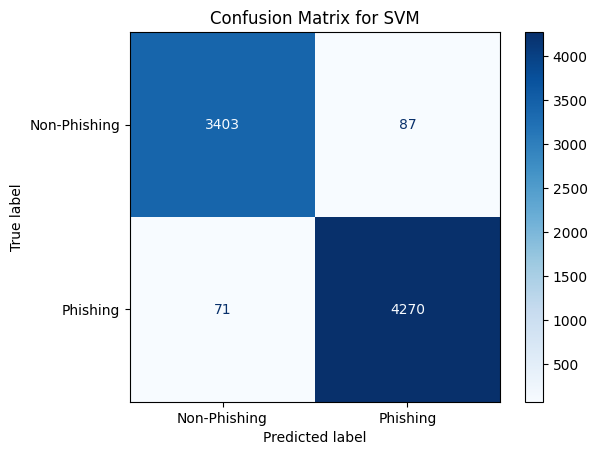

<Figure size 600x600 with 0 Axes>

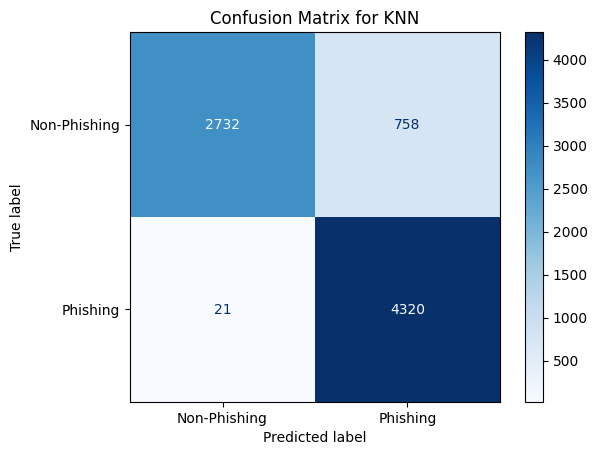

245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 600x600 with 0 Axes>

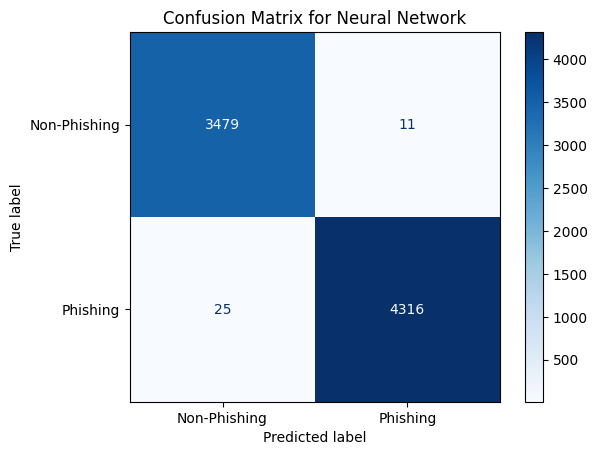

In [58]:
for name, model in trained_models.items():
    if name == "Neural Network" or name == "LSTM":
        if name == "Neural Network":
            y_pred = (model.predict(X_test_ml.toarray()) > 0.5).astype(int)  # .toarray() since we're using TF-IDF for NN
        else:
            y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test_ml)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Phishing", "Phishing"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


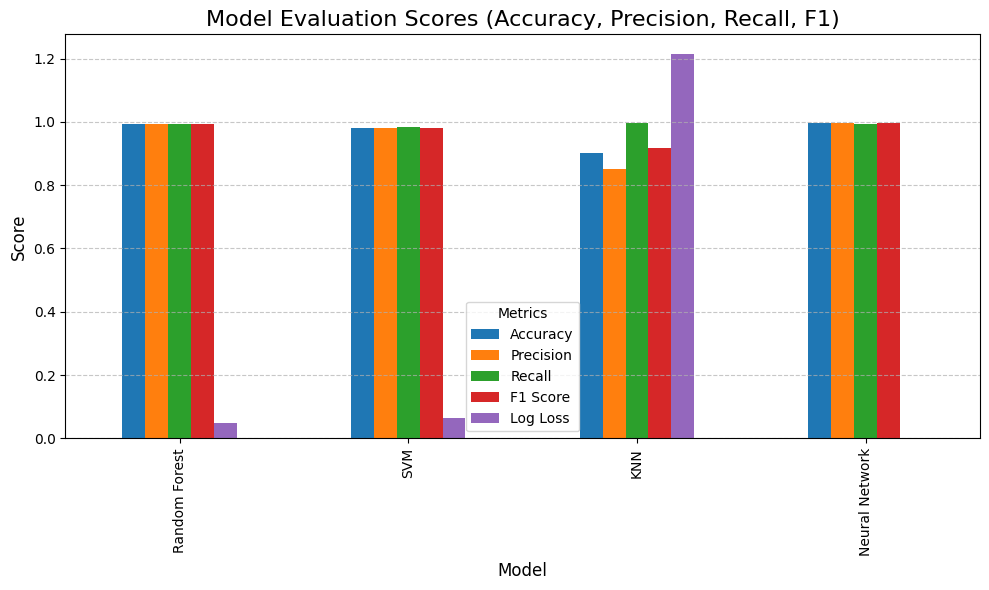


Model Evaluation Table:
                Accuracy  Precision    Recall  F1 Score  Log Loss
Random Forest   0.992977   0.993097  0.994241  0.993669  0.047910
SVM             0.979824   0.980032  0.983644  0.981835  0.065549
KNN             0.900524   0.850729  0.995162  0.917295  1.215892
Neural Network  0.995403   0.997458  0.994241  0.995847       NaN


In [59]:
df_results = pd.DataFrame(results).T  # Transpose to get models as rows
fig, ax = plt.subplots(figsize=(10, 6))
df_results.plot(kind='bar', ax=ax)
ax.set_title("Model Evaluation Scores (Accuracy, Precision, Recall, F1)", fontsize=16)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.legend(title="Metrics", fontsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\nModel Evaluation Table:")
print(df_results)

In [60]:
def test_email(input_text, trained_models, vectorizer, vectorizer_domains):
    """Classify a new email as phishing or non-phishing using all trained models."""
    # Clean and process the text
    cleaned_input = clean_text(input_text)
    input_vector_text = vectorizer.transform([cleaned_input])

    # Extract URL domains if any
    domains_input = ' '.join(extract_domain(url) for url in extract_urls(input_text))
    input_vector_domains = vectorizer_domains.transform([domains_input])

    # Create URL features (has_url and num_urls)
    num_urls = len(extract_urls(input_text))  # Number of URLs in the email
    has_url = 1 if num_urls > 0 else 0        # Whether the email has URLs

    # Concatenate the text and URL features
    input_vector_urls = np.array([[has_url, num_urls]])  # The URL-related features as a matrix
    input_vector = hstack([input_vector_text, input_vector_urls, input_vector_domains])  # Combine all features

    results = {}
    for model_name, model in trained_models.items():
        # Get prediction from the model
        prediction = model.predict(input_vector)
        results[model_name] = "Phishing" if prediction[0] == 1 else "Non-Phishing"

    # Neural network prediction
    nn_prediction = nn_model.predict(input_vector.toarray())
    results["Neural Network"] = "Phishing" if nn_prediction[0] > 0.5 else "Non-Phishing"

    return results

In [61]:
new_email = "Long Time no See bro!"
results = test_email(new_email, trained_models, vectorizer, vectorizer_domains)

# Display results from all trained models
print("\nResults from all trained models:")
for model_name, result in results.items():
    print(f"{model_name}: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step

Results from all trained models:
Random Forest: Phishing
SVM: Phishing
KNN: Phishing
Neural Network: Phishing
